# Unsupervised State-Inference
In reinforcement learning, it's often useful to assume that we can describe a problem in a discrete and finite set of states. For example, we might have an known number of independent bandits, or a grid-world with defined locations of objects. One reason this representation is useful is that it can dramtically simplify the problem of planning: given a known set of states $S$, a transition function $T(s,a,s') = p(s'|s,a)$ that defines the conditional probability of arriving in state $s'$ having taken action $a$ in state $s'$, and reward function $R(s, a, s')$ that defines the values over our state-action space, there are known polynomial time planning algorithms. 

In naturalistic enviornments, however, it can be difficult to translate raw perceptual stimuli into discrete states. Typically, states are an assumption of an enviornment and we often lack a principaled way to discover them from observation alone.  

Here, the goal is to discover states using an unsupervised learning algorithm.  We'll assume states are discrete, independent latent variables and use variational inference to learn conditional probability distribution over states. More formally, given a real-valued observation vector $x\in R^d$, we want to learn a paramterized function $f_\theta(x)$ that defines a probability distribution over states $s$. We'll assume that we don't have access to the states, but only have the observation tuples $(x, x')$ that define transitions an agent makes in an enviornment. We will use a discrete variaitional autoencoder (VAE) for our unsupervised algorithm.




In [8]:
%matplotlib inline
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import fftconvolve
from torch.distributions.categorical import Categorical
from torch.utils.data import Dataset
from sklearn.metrics import pairwise_distances
from random import choices



## Toy World
First, it's useful to construct a toy world and the stimuli we'll need for the model. I'm making the assumption that the underlying MDP is a $n\times n$ grid-world that's embedded in much higher dimensional observational space. To do so, I'll construct a much larger grid with dimensions $m\times m$, where $m > n$, and evenly space the states in the grid. I then add a couple of sources of noise and convole the observations with a Gaussian kernel to generate the observations.  This increases the dimensionality substantially (going from $n^2$ to $m^2$) and adds significant overlap between the observations.

We can think of these observations as a toy model for soemthing like a robot's estimate of it's position, or a perhaps as a model of hippocampal grid cells.  Importantly, this doesn't have to be exclusively a spatial model -- none of the subsequent modeling uses visual inductive biases and I'm hopeful this is more general toy model.

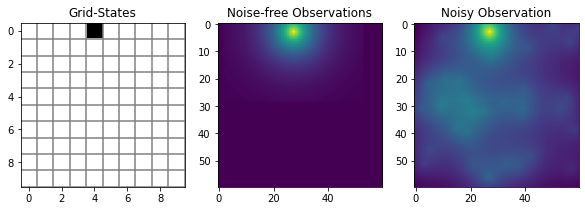

In [9]:
# Discritized states: a 10x10 grid of states, which we embed by spacing 
# evenly in a nXn space
h, w = 10, 10
map_height = 60

rbf_kernel_size = 51 # must be odd
rbf_kernel_scale = .15

assert map_height % h == 0
assert map_height % w == 0
multiplier = map_height // h

x = [ii for ii in range(h) for _ in range(h)]
y = [ii for _ in range(w) for ii in range(w)]
coordinates = np.array([x, y]).T * multiplier + multiplier//2
states = {ii: c for ii, c in enumerate(coordinates)}

# The state-location is smoothed by convoling an RBF kernel with the 
# one-hot representation of the location in the nXn Grid

# Create an rbf kernel for smoothing.
def contruct_rbf_kernel(kernel_size: int = 5, len_scale: float = 0.1):
    assert kernel_size % 2 == 1
    
    kernel = torch.empty([kernel_size, kernel_size]).float()
    center = torch.ones([1,1]) * kernel_size // 2
    
    def rbf(x: torch.tensor) -> float:
        dist = ((x - center) ** 2).sum() ** 0.5
        return torch.exp(-len_scale * dist)
    
    for r in range(kernel_size):
        for c in range(kernel_size):
            kernel[r,c] = rbf(torch.tensor([r,c ]))

    return kernel
kernel=contruct_rbf_kernel(rbf_kernel_size, rbf_kernel_scale)

# embed the location with a convolution 
def embed_location(x, y, map_height, kernel):
    grid = torch.zeros((map_height, map_height))
    grid[x,y] = 1.0
    return fftconvolve(grid, kernel, mode='same')    

### Add a noise process to the observation
# this representation makes it easy to corrupt our 
# locations for a more difficult inference task.
def corrupt_location(coords, width=2, p=0.25):
    if p > np.random.rand():
      coords[0] += np.random.randint(-width, width+1)
    if p > np.random.rand():
      coords[1] += np.random.randint(-width, width+1)
    return coords 

def corrupt_embedding(x, y, map_height, kernel, 
                      width=2,
                      log_normal_scale=0.05,
                      log_normal_mean=-2,
                      corruption_probability=0.01):
  
    xc, yc = corrupt_location(np.array([x, y]), width=width)

    grid = torch.zeros((map_height, map_height))
    grid[xc,yc] = 1.0    
    corrupted_mask = torch.exp(
        torch.randn(map_height, map_height)*log_normal_scale + log_normal_mean
        )
    corrupted_mask *= torch.rand(map_height, map_height) < corruption_probability
    grid += corrupted_mask
    return fftconvolve(grid, kernel, mode='same')    



# show an example location
s = 4
x, y = states[s]
raw_state = np.ones((h,w))
raw_state[0, s] = 0
fig, axes = plt.subplots(1, 3, figsize=(10, 20))
axes[0].imshow(raw_state, cmap='gray')
def plt_lines(h, w, ax):
  y_lim = ax.get_ylim()
  x_lim = ax.get_xlim()
  for h0 in range(h):
    ax.plot([h0+0.5, h0+0.5], [-0.5, w+0.5], c='gray')
  for w0 in range(w):
    ax.plot([-0.5, h+0.5], [w0+0.5, w0+0.5], c='gray')
  ax.set_ylim(y_lim)
  ax.set_xlim(x_lim)
plt_lines(h,w, axes[0])
axes[1].imshow(embed_location(x, y, map_height, kernel))
axes[2].imshow(corrupt_embedding(x, y, map_height, kernel))
axes[0].set_title('Grid-States')
axes[1].set_title('Noise-free Observations')
axes[2].set_title('Noisy Observation')
plt.show()

Notably, there is a overlap in our observation space. We can control this overlap parametrically by changing the length scale of our convolution kernel (this is akin to a wider belief distribution)

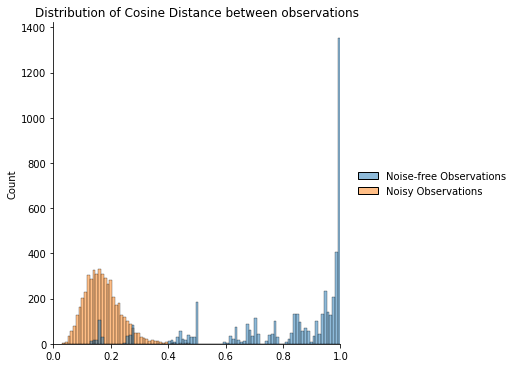

In [10]:
def pairwise_embedding_distances(embedding_function, states, map_height, kernel):
  sample_embeddings = {}
  for s, (x, y) in states.items():
    sample_embeddings[s] = embedding_function(x, y, map_height, kernel).reshape(-1)

  distances = pairwise_distances(
      np.array(list(sample_embeddings.values())),
      metric='cosine'
      )

  mask = np.tril(np.ones_like(distances, dtype=bool), k=-1)
  return distances.reshape(-1)[mask.reshape(-1)]
  

sns.displot(
   {
    'Noise-free Observations': pairwise_embedding_distances(
       embed_location, states, map_height, kernel
       ),
    'Noisy Observations': pairwise_embedding_distances(
       corrupt_embedding, states, map_height, kernel
       ),
   },
   bins=100
)

plt.title('Distribution of Cosine Distance between observations')
plt.xlim([0,1])
plt.show()

### Random Walk 
Define a random walk over the grid-world and plot a sample trajectory

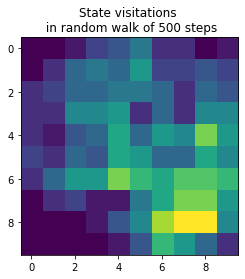

In [11]:
# Define a random walk between coordinate neighbors. 
# This is will be used to during training

def make_transitions(h, w):
  t = np.zeros((h*w,h*w))
  for s0 in range(h*w):

    # if s0 + 1

    if s0 - w >= 0:
      t[s0, s0-w] = 1
    if s0 + w + 1 < h*w:
      t[s0, s0+w] = 1

    if (s0 + 1) % w > 0:
      t[s0, s0+1] = 1

    if s0 % w > 0:
      t[s0, s0-1] = 1

  # normalize
  t /= np.tile(t.sum(axis=1).reshape(-1, 1), h*w)

  return t


grid_size = 10
ground_truth_transitions = make_transitions(grid_size,grid_size)

# derive the edges of the graph
edges = {}
for s, t in enumerate(ground_truth_transitions):
  edges[s] = np.where(t > 0)[0]
# print(edges)

# 
def generate_random_walk(walk_length, edges):
  random_walk = []
  s = choices(list(edges.keys()))[0]
  random_walk.append(s)
  state_counts = np.zeros(len(edges))
  for _ in range(walk_length):
    s = choices(edges[s])[0]
    state_counts[s] += 1
    random_walk.append(s)

  return state_counts, random_walk

n = 500
state_counts, walk = generate_random_walk(n, edges)
plt.imshow(state_counts.reshape(grid_size,grid_size))
plt.title(f'State visitations \n in random walk of {n} steps')
plt.show()

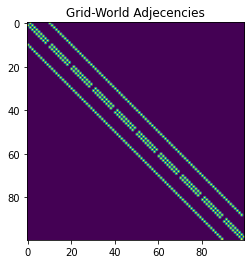

In [12]:
plt.imshow(ground_truth_transitions > 0)
plt.title('Grid-World Adjecencies')
plt.show()

## Discrete State-VAE
The core idea is to use a discrete Variational Autoencoder, where states are represented as one-hot vector embeddings. The VAE is an encoder/decoder model, where the encoder learns a parameterized probability distribution over embeddings and the decoder reconstructs the original input vector from the vector embedding. 

The model has three key components:
* An encoder model: $f_\theta(x) = \omega$
* A Gumbel-Sofmax probability distribution over states $p_\omega(z) \propto exp(\omega + \epsilon)$, where $ \epsilon$ is an external source of noise drawn from the Gumbel distribution.
* A decoder model: $d_\theta(z) = x$

The model is trained with stochastic variational gradient descent: an input is passed through the decoder, a state is sampled from the Gumbel-softmax distribution, and the input is reconstructed by the decoder. This forward pass is used to calculate the ELBO loss function:
$$ELBO(x) = \log q(x|z) - KL(q(z|x)||p(z))$$
where $\log q(x|z)$ is the reconstruction loss of the network and $KL(q(z|x)||p(z))$ is the KL diveregence of the learned embedding distribution and a prior over states. Under gentle assumptions, $-\log q(x|z)$ is the mean squared error of the reconstructed output relative to the input and the $KL(q(z|x)||p(z))$ becomes the entropy of the embedding distribution.




### Model
This is the code for the VAE

In [13]:
def flatten_make_one_hot(x: torch.tensor, d: int) -> torch.tensor:
  n = x.shape[0]
  x = F.one_hot(x.long(), d).view(n, -1).float()
  return x


class MLP(nn.Module):
  def __init__(
      self, 
      input_size:int,
      hidden_sizes: list,
      output_size:int,
      dropout: float = 0.01,
      ):
    super().__init__()        
    self.nin = input_size
    self.nout = output_size

    # define a simple MLP neural net
    self.net = []
    hs = [self.nin] + hidden_sizes + [self.nout]
    for h0,h1 in zip(hs, hs[1:]):
        self.net.extend([
                nn.Linear(h0, h1),
                nn.BatchNorm1d(h1),
                nn.Dropout(p=dropout),
                nn.ReLU(),

            ])
    self.net.pop()
    self.net.pop() # pop the last ReLU for the output layer
    self.net = nn.Sequential(*self.net)

  def forward(self, x):
    return self.net(x)


class VAE(nn.Module):
  def __init__(
      self, 
      encoder: nn.Module, 
      decoder: nn.Module, 
      z_dim:int, 
      beta: float = 1, 
      tau: float = 1,
      gamma: float = 1):
    super().__init__()        
    self.encoder = encoder
    self.decoder = decoder
    self.z_dim = z_dim
    self.beta = beta
    self.tau = tau
    self.gamma = gamma

  def reparameterize(self, logits):
    # either sample the state or take the argmax
    if self.training:
      z = F.gumbel_softmax(logits=logits, tau=self.tau, hard=False)
    else:
      s = torch.argmax(logits, dim=1)
      z = flatten_make_one_hot(s, self.z_dim)
    return z

  def encode(self, x):
    logits = self.encoder(x)
    z = self.reparameterize(logits)
    return logits, z

  def forward(self, x):
    _, z = self.encode(x)
    return self.decoder(z)

  def kl_loss(self, logits):
    return Categorical(logits=logits).entropy().mean()

  def reconstruction_loss(self, x, z):
    x_hat = self.decoder(z)
    return F.mse_loss(x_hat, x)

  def loss(self, x):
    logits, z = self.encode(x)
    return self.loss_from_embedding(x, logits, z)

  def loss_from_embedding(self, x, logits, z):
    kl_loss = self.kl_loss(logits)
    recon_loss = self.reconstruction_loss(x, z)
    return recon_loss + kl_loss * self.beta
    
  def state_probability(self, x):
    with torch.no_grad():
      logits = self.encoder(x)
      return Categorical(logits=logits).probs

  def decode_state(self, s: int):
    z = flatten_make_one_hot(s, self.z_dim)
    with torch.no_grad():
      return self.decoder(z)

  def anneal_tau(self):
    self.tau *= self.gamma
    


In [14]:
# def flatten_make_one_hot(x: torch.tensor, d: int) -> torch.tensor:
#   n = x.shape[0]
#   x = F.one_hot(x.long(), d).view(n, -1).float()
#   return x


# class MLP(nn.Module):
#   def __init__(
#       self, 
#       input_size:int,
#       hidden_sizes: list,
#       output_size:int,
#       dropout: float = 0.01,
#       ):
#     super().__init__()        
#     self.nin = input_size
#     self.nout = output_size

#     # define a simple MLP neural net
#     self.net = []
#     hs = [self.nin] + hidden_sizes + [self.nout]
#     for h0,h1 in zip(hs, hs[1:]):
#         self.net.extend([
#                 nn.Linear(h0, h1),
#                 nn.BatchNorm1d(h1),
#                 nn.Dropout(p=dropout),
#                 nn.ReLU(),

#             ])
#     self.net.pop()
#     self.net.pop() # pop the last ReLU for the output layer
#     self.net = nn.Sequential(*self.net)

#   def forward(self, x):
#     return self.net(x)


# class mDVAE(nn.Module):
#   def __init__(
#       self, 
#       encoder: nn.Module, 
#       decoder: nn.Module, 
#       z_dim:int, 
#       beta: float = 1, 
#       tau: float = 1,
#       gamma: float = 1):
#     super().__init__()        
#     self.encoder = encoder
#     self.decoder = decoder
#     self.z_dim = z_dim
#     self.beta = beta
#     self.tau = tau
#     self.gamma = gamma

#   def reparameterize(self, logits):
#     logits = .view(-1, 2, self.z_dim//2)
#     # either sample the state or take the argmax
#     if self.training:
#       z = F.gumbel_softmax(logits=logits, tau=self.tau, hard=False)
#     else:
#       s = torch.argmax(logits, dim=-1)
#       z = flatten_make_one_hot(s, self.z_dim)
#     return z.view(-1, self.z_dim)

#   def encode(self, x):
#     logits = self.encoder(x)
#     z = self.reparameterize(logits)
#     return logits, z

#   def forward(self, x):
#     _, z = self.encode(x)
#     return self.decoder(z)

#   def kl_loss(self, logits):
#     return Categorical(logits=logits).entropy().mean()

#   def reconstruction_loss(self, x, z):
#     x_hat = self.decoder(z)
#     return F.mse_loss(x_hat, x)

#   def loss(self, x):
#     logits, z = self.encode(x)
#     return self.loss_from_embedding(x, logits, z)

#   def loss_from_embedding(self, x, logits, z):
#     kl_loss = self.kl_loss(logits)
#     recon_loss = self.reconstruction_loss(x, z)
#     return recon_loss + kl_loss * self.beta
    
#   def state_probability(self, x):
#     with torch.no_grad():
#       logits = self.encoder(x)
#       return Categorical(logits=logits).probs

#   def decode_state(self, s: int):
#     z = flatten_make_one_hot(s, self.z_dim)
#     with torch.no_grad():
#       return self.decoder(z)

#   def anneal_tau(self):
#     self.tau *= self.gamma
    


### Training Functions
Helper functions to train the model

In [15]:
# helper functions for training
QUIET = False
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(model, train_loader, optimizer, epoch, clip_grad = None):
  model.train()

  train_losses = []
  for x in train_loader:
    x = x.to(DEVICE).float()

    optimizer.zero_grad()
    loss = model.loss(x)
    loss.backward()

    if clip_grad:
      torch.nn.utils.clip_grad_norm(model.parameters(), clip_grad)

    optimizer.step()
    train_losses.append(loss.item())

  return train_losses
  
def eval_loss(model, data_loader):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for x in data_loader:
      x = x.to(DEVICE).float()
      loss = model.loss(x)
      total_loss += loss * x.shape[0]
    avg_loss = total_loss / len(data_loader.dataset)

  return avg_loss.item()

def eval_embeddings(model, states, h, w):
  model.eval()
  inferred_states = {}
  for s, (x, y) in states.items():
    X_hat = model.state_probability(test_data[s,:].view(1, -1).to(DEVICE))

    # get grid position
    r, c = s // w, s % w
    inferred_states[s] = (X_hat, np.array([r, c]))

  grid_dist = np.zeros((h*w, h*w))
  embd_dist = np.zeros((h*w, h*w))
  for s in states.keys():
    x, coords = inferred_states[s]
    for sp in states.keys():
      xp, coords_p = inferred_states[sp]
      grid_dist[s, sp] = np.linalg.norm(coords-coords_p)
      embd_dist[s, sp] = torch.matmul(x, xp.T).detach().cpu().numpy().reshape(-1)[0]

  return {
      'Grid Distance': grid_dist,
      'Embedding Angle Cosine': embd_dist,
  }


def train_epochs(model, train_loader, test_loader, train_args):
  epochs, lr = train_args['epochs'], train_args['lr']
  grad_clip = train_args.get('grad_clip', None)
  optimizer = optim.AdamW(model.parameters(), lr=lr)

  train_losses = []
  test_losses = [eval_loss(model, test_loader)]
  for epoch in range(epochs):
    model.train()
    train_losses.extend(train(model, train_loader, optimizer, epoch, grad_clip))
    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)

    model.anneal_tau()

    if not QUIET:
      print(f'Epoch {epoch}, ELBO Loss (test) {test_loss:.4f}')

  embedding_eval = eval_embeddings(model, states, h, w)

  return train_losses, test_losses, embedding_eval


### Generate Dataset
Sample states from a Random walk on the grid-world and then generate noisy observations

In [16]:
### Simulation Parameters
N_TRAINING_EXAMPLES = 10000

######


#### Uniform sampling of states
# create a sample dataset with random corruptions
def sample_states_uniform(n):
  return np.random.choice(len(edges), n)

def sample_states_walk(n):
  return generate_random_walk(n, edges)[1]

# def sample_corrupted_state(n):
#   x, y = states[np.random.choice(h*w)]
  # return corrupt_embedding(x, y, map_height, kernel).reshape(-1)


def generate_train_data(n, sampler):
  x = np.array([
      corrupt_embedding(states[s][0], states[s][1], map_height, kernel).reshape(-1)
      for s in sampler(n)
  ])

  return torch.tensor(x)

training_data = generate_train_data(N_TRAINING_EXAMPLES, sample_states_walk)
_, d = training_data.shape

# for test, use the uncorrupted dataset
test_data = torch.tensor(np.array([
    embed_location(x, y, map_height, kernel).reshape(-1) for x,y in coordinates
    ]))


#### Random Walk between states

### Train the Model

In [17]:
### Model Parameters
N_EPOCHS = 20
BATCH_SIZE = 64
EMBEDDING_DIM = len(states)*h
LR = 5e-4
beta = 2.0
tau = 2.0
gamma = 0.9
dropout = 0.1
vae_kwargs = dict(beta=beta, tau=tau, gamma=gamma)

In [18]:
# create the model
encoder = MLP(d, [d // 10], EMBEDDING_DIM, dropout=dropout)
decoder = MLP(EMBEDDING_DIM, [d // 10], d, dropout=dropout)
vae_model = VAE(encoder, decoder, EMBEDDING_DIM, **vae_kwargs).to(DEVICE)

# Create the dataloaders from the dataset
train_loader = data.DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

# Train the the model
train_losses, test_losses, embedding_eval = train_epochs(
    vae_model, train_loader, test_loader, dict(epochs=N_EPOCHS, lr=LR)
    )

Epoch 0, ELBO Loss (test) 32.6671
Epoch 1, ELBO Loss (test) 14.3758
Epoch 2, ELBO Loss (test) 8.5331
Epoch 3, ELBO Loss (test) 5.3256
Epoch 4, ELBO Loss (test) 3.3515
Epoch 5, ELBO Loss (test) 1.6084
Epoch 6, ELBO Loss (test) 0.9171
Epoch 7, ELBO Loss (test) 0.7339
Epoch 8, ELBO Loss (test) 0.4493
Epoch 9, ELBO Loss (test) 0.6082
Epoch 10, ELBO Loss (test) 0.5007
Epoch 11, ELBO Loss (test) 0.5297
Epoch 12, ELBO Loss (test) 0.2815
Epoch 13, ELBO Loss (test) 0.3413
Epoch 14, ELBO Loss (test) 0.4658
Epoch 15, ELBO Loss (test) 0.2076
Epoch 16, ELBO Loss (test) 0.4808
Epoch 17, ELBO Loss (test) 0.2436
Epoch 18, ELBO Loss (test) 0.2043
Epoch 19, ELBO Loss (test) 0.1862


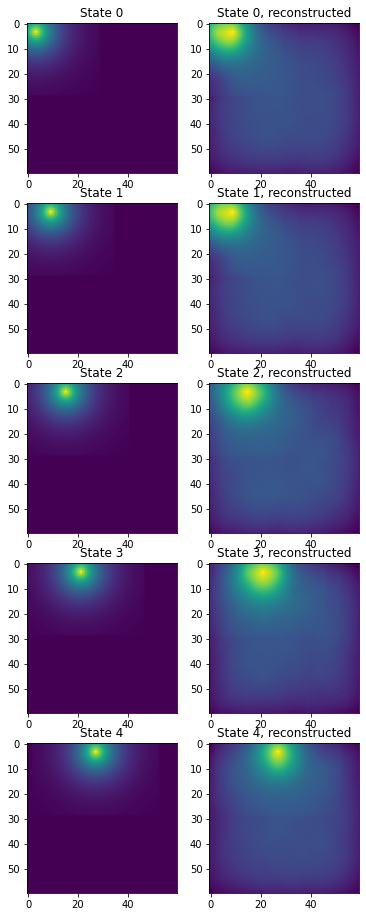

In [19]:
vae_model.eval()
s = np.random.randint(0, EMBEDDING_DIM)
ii = 0
fig, axes = plt.subplots(5, 2, figsize=(6, 16))
for s in range(5):
  X_hat = vae_model(test_data[s,:].view(1, -1).to(DEVICE))

  axes[ii][0].imshow(test_data[s, :].view(map_height, map_height))
  axes[ii][1].imshow(X_hat.view(map_height, map_height).detach().cpu().numpy())
  axes[ii][0].set_title(f'State {ii}')
  axes[ii][1].set_title(f'State {ii}, reconstructed')

  ii+=1



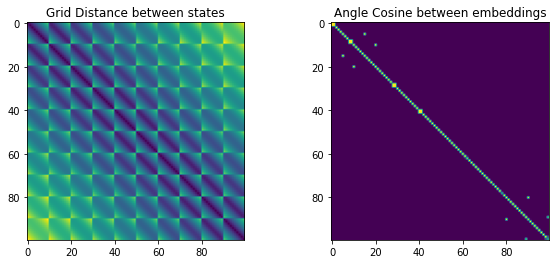

Mean Embedding Similarity: 0.0016166281396647866


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(embedding_eval['Grid Distance'])
axes[1].imshow(embedding_eval['Embedding Angle Cosine'])
axes[0].set_title('Grid Distance between states')
axes[1].set_title('Angle Cosine between embeddings')
plt.show()


embd_dot = embedding_eval['Embedding Angle Cosine']
idx = np.tril(np.ones_like(embd_dot, dtype=bool), k=-1)
print(f"Mean Embedding Similarity: {embd_dot.reshape(-1)[idx.reshape(-1)].mean()}")
